# Project:Sentiment analysis of Amazon Fine Food Reviews

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#dl">Deep Learning Models</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This dataset consists of reviews of fine foods from amazon from [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews). The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

>Data includes:

> - Reviews from Oct 1999 - Oct 2012
> - 568,454 reviews
> - 256,059 users
> - 74,258 products
> - 260 users with > 50 reviews

| Column name   | Desc         |
|:------------- |:-------------| 
|ID  | Numerical Review Id   |
|ProductID| unique identifier for the product|
|UserId |unique identifier for the user|
|HelpfulnessNumerator |  number of users who found the review helpful|
|HelpfulnessDenominator | number of users who indicated whether they found the review helpful or not|
|Score | rating between 1 and 5|
|Time | timestamp for the review|
|Summary | brief summary of the review|
|Text | Whole text of the review|

> The Question/Objective of the analysis is determine whether a review is Positive or negtive?
Build an RNN and LSTM model around it?

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
#reading the Datafile
path = r'...\Reviews.csv'
df = pd.read_csv(path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


### The structure of your dataset?

> The Data set contains 568,454 obseravtions and 10 columns

### The main feature(s) of interest in your dataset?

> The score and text columns 

### Data Cleaning :

- Replace Score column with 0 or 1 for scores more than 3
- Drop na values
- Feature engineer the helpfulness columns to % of Helpfulness
- Remove Duplicates from "UserId","ProfileName","Time","Text" columns

In [3]:
# make a copy of the original df
df_clean = df.copy()

In [4]:
#dropping all null values
df_clean = df_clean.dropna()

In [5]:
#creating a new column Helpfulness_Perc that binds the the other 2 columns
df_clean["Helpfulness_Perc"] = df_clean[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
df_clean = df_clean.drop(["HelpfulnessNumerator","HelpfulnessDenominator"], axis=1)
df_clean.head(1)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_Perc
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,100.0


In [6]:
# Changing Score column to dummy variable filtering only higher scores of 4 and 5
df_clean["Score"] = df_clean["Score"].apply(lambda x : 1 if x > 3 else 0)
df_clean.head(3)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_Perc
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,100.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,100.0


In [7]:
#sorting data , dropping duplicates from "UserId","ProfileName","Time","Text" columns
df_clean=df_clean.sort_values('ProductId', kind='quicksort', na_position='last') 
df_clean=df_clean.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
df_clean.shape

(393919, 9)

In [8]:
df_clean.Score.value_counts(normalize=True)

1    0.779467
0    0.220533
Name: Score, dtype: float64

<a id='eda'></a>
## Exploratory Data Analysis

### Research Questions:
> What is the most common score?
> How much are the reviews helpful in terms of user ratings?
> what are the most common words in the reviews?

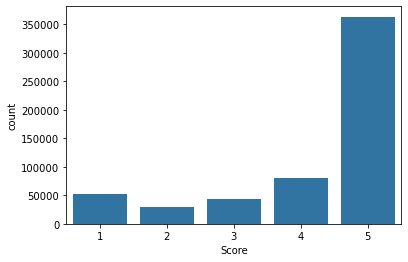

In [13]:
# Plotting Score 
color = sb.color_palette()[0]
sb.countplot(data=df , x='Score', color=color);

In [14]:
df.Score.value_counts(normalize = True)

5    0.638818
4    0.141896
1    0.091948
3    0.075013
2    0.052327
Name: Score, dtype: float64

> Most of the reviews are positive ( ~78 %)

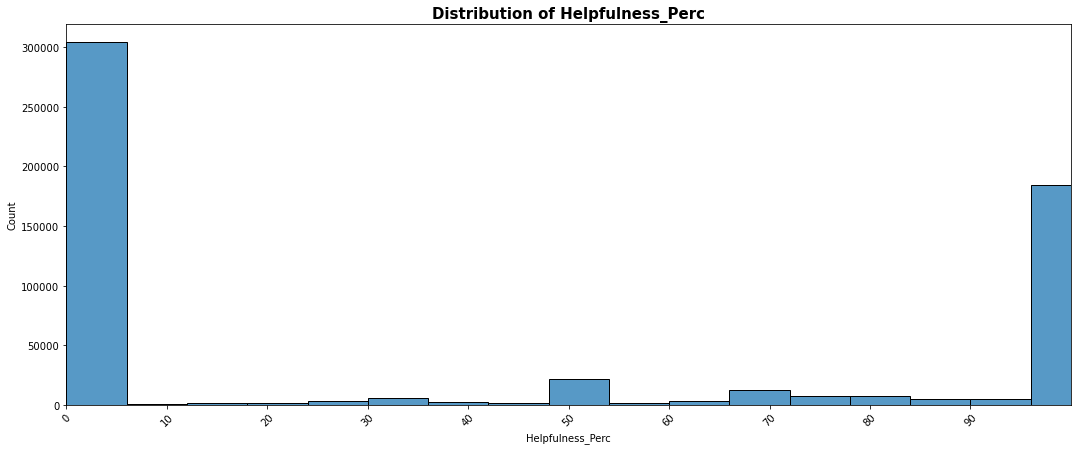

In [21]:
plt.figure(figsize=(18,7))
sb.histplot(data=df_clean["Helpfulness_Perc"], bins=50)
plt.title("Distribution of Helpfulness_Perc",fontweight='bold', fontsize=15)
plt.xticks(range(0,100,10), rotation=45)
plt.xlim(0, 100);

> Seems most of the scores were not helpful or unavailable, however a significant number of reviews where found helpful.

In [23]:
#creating a new Column out of Helpfulness percentage
df_clean.loc[df_clean["Helpfulness_Perc"] >= 75, 'Helpfulness_indicator'] = 'Useful'
df_clean.loc[(df_clean["Helpfulness_Perc"] > 40) & (df_clean["Helpfulness_Perc"] < 75), 'Helpfulness_indicator'] = 'Intermediate'
df_clean.loc[(df_clean["Helpfulness_Perc"] > 0) & (df_clean["Helpfulness_Perc"] <= 40), 'Helpfulness_indicator'] = 'Not Useful'
df_clean.loc[df_clean["Helpfulness_Perc"] == 0, 'Helpfulness_indicator'] = 'Not Available'

df_clean = df_clean.drop(["Helpfulness_Perc"], axis=1)

df_clean.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_indicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available


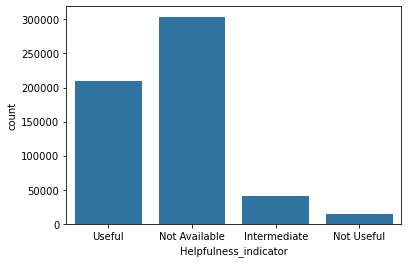

In [24]:
#plotting Helfulness indicator column
sb.countplot(data=df_clean, x='Helpfulness_indicator', color=color);

> Over 200 K users found the reviews to be usefull.

In [31]:
df_clean[['Helpfulness_indicator','Score']].groupby('Helpfulness_indicator').mean()

,Score
Helpfulness_indicator,
Intermediate,0.510843
Not Available,0.806970
Not Useful,0.247908
Useful,0.832971


<AxesSubplot:xlabel='Helpfulness_indicator'>

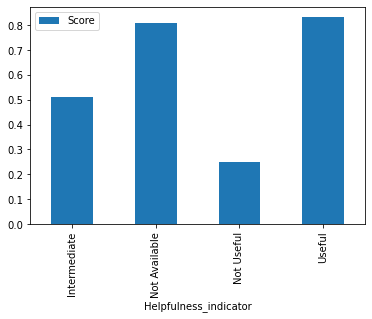

In [34]:
df_clean[['Helpfulness_indicator','Score']].groupby('Helpfulness_indicator').mean().plot(kind = 'bar')

> More than 80% of users who found the helpfulness score to be usefull gave a high score, then Not available an the intermediate

There are 248532867 words in the combination of all review.


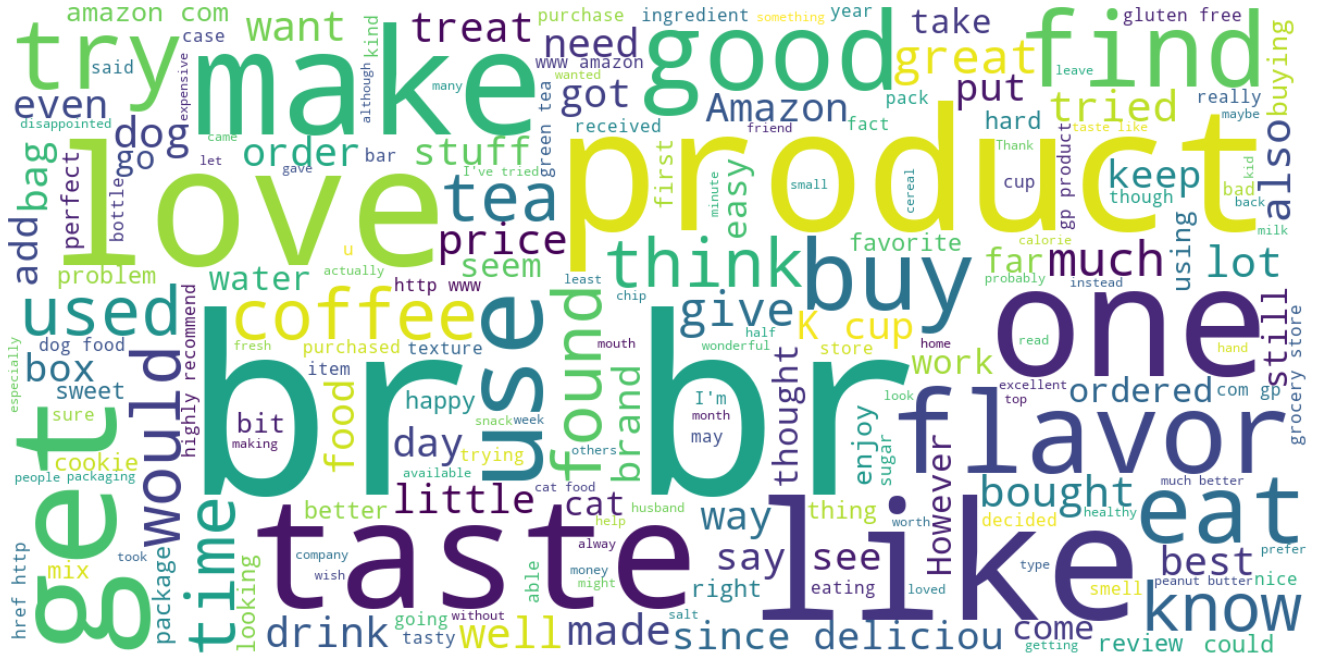

In [39]:
#generating a Wordcloud from most frequently used words in the text column
from nltk.corpus import stopwords
from wordcloud import WordCloud

text = " ".join(review for review in df_clean["Text"])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
print(wordcloud.words_.keys())

dict_keys(['br br', 'product', 'love', 'like', 'one', 'taste', 'get', 'make', 'flavor', 'use', 'good', 'find', 'buy', 'try', 'eat', 'coffee', 'found', 'think', 'would', 'time', 'used', 'know', 'tea', 'great', 'much', 'give', 'bought', 'well', 'lot', 'made', 'also', 'tried', 'dog', 'price', 'want', 'drink', 'treat', 'best', 'Amazon', 'got', 'day', 'bag', 'even', 'order', 'need', 'food', 'little', 'way', 'deliciou', 'since', 'box', 'K cup', 'say', 'brand', 'add', 'put', 'keep', 'see', 'stuff', 'ordered', 'come', 'take', 'seem', 'still', 'cat', 'water', 'thought', 'However', 'work', 'go', 'far', 'easy', 'amazon com', 'bit', 'enjoy', 'using', 'buying', 'problem', 'better', 'review', 'hard', 'could', 'cookie', 'mix', 'first', 'thing', 'right', 'favorite', 'happy', 'looking', 'package', 'sweet', 'perfect', 'ingredient', 'eating', 'purchase', 'really', 'sure', 'purchased', 'nice', 'going', 'pack', 'grocery store', 'year', 'kind', 'case', 'bad', 'received', 'able', 'gluten free', 'item', "I'm"

> Most frequent words used in the review were 
 - Love
 - like
 - Good
 - great
 - best 

<a id='dl'></a>
## Deep Learning Models

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, Dropout
from sklearn.model_selection import train_test_split
import re
from bs4 import BeautifulSoup
from keras import initializers

#### Preprocessing of text data

In [10]:
#define 
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

# 
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             
    review = BeautifulSoup(review, 'lxml').get_text()   
    review = decontract(review)                         
    review = re.sub("\S*\d\S*", "", review).strip()     
    review = re.sub('[^A-Za-z]+', ' ', review)          
    review = review.lower()                             
    review = [word for word in review.split(" ") if not word in stop_words] 
    review = " ".join(review)
    review.strip()
    return review
df_clean['Text'] = df_clean['Text'].apply(lambda x: preprocess_text(x))
df_clean['Text'].head()

150492    days person says chicken soup probably going f...
150509    title chicken soup riceauthor maurice sendakre...
150510    charming rhyming book describes circumstances ...
150511    set aside least hour day read son point consid...
150512    remembered book childhood got kids good rememb...
Name: Text, dtype: object

In [12]:
train_df, test_df = train_test_split(df_clean, test_size = 0.3, random_state = 42)
keep_col = ['Id','ProductId','Text','Score']
train_df = train_df[keep_col]
test_df = test_df[keep_col]
print(train_df.shape)
print(test_df.shape)

(275743, 4)
(118176, 4)


In [14]:
top_words = 6000 #setting maximum features
tokenizer = Tokenizer(num_words=top_words) 
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 130
embedding_vecor_length = 32
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Score']

### RNN Model

In [19]:
## building RNN
rnn_hidden_dim = 5
word_embedding_dim = 130
model_rnn = Sequential()
model_rnn.add(Embedding(top_words, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 50-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=X_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 130)         780000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5)                 680       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 780,686
Trainable params: 780,686
Non-trainable params: 0
_________________________________________________________________


In [21]:
import keras
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [25]:
batch_size = 64
model_rnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

Epoch 1/5
4309/4309 [==============================] - 303s 70ms/step - loss: 0.2771 - accuracy: 0.8844 - val_loss: 0.2779 - val_accuracy: 0.8837
Epoch 2/5
4309/4309 [==============================] - 297s 69ms/step - loss: 0.2679 - accuracy: 0.8885 - val_loss: 0.2795 - val_accuracy: 0.8829
Epoch 3/5
4309/4309 [==============================] - 301s 70ms/step - loss: 0.2633 - accuracy: 0.8913 - val_loss: 0.2724 - val_accuracy: 0.8870
Epoch 4/5
4309/4309 [==============================] - 300s 70ms/step - loss: 0.2603 - accuracy: 0.8924 - val_loss: 0.2692 - val_accuracy: 0.8877
Epoch 5/5
4309/4309 [==============================] - 299s 69ms/step - loss: 0.2579 - accuracy: 0.8934 - val_loss: 0.2761 - val_accuracy: 0.8851


In [26]:
score, acc = model_rnn.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

1847/1847 [==============================] - 30s 16ms/step - loss: 0.2761 - accuracy: 0.8851
Test score: 0.27611279487609863
Test accuracy: 0.8850951194763184


### LSTM Model

In [46]:
#Building model 
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           192032    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Model fitting
model.fit(X_train,y_train, epochs=2, batch_size=64, validation_split=0.2)


Epoch 1/2
3447/3447 [==============================] - 389s 113ms/step - loss: 0.2925 - accuracy: 0.8776 - val_loss: 0.2645 - val_accuracy: 0.8886
Epoch 2/2
3447/3447 [==============================] - 404s 117ms/step - loss: 0.2431 - accuracy: 0.9001 - val_loss: 0.2425 - val_accuracy: 0.9012


In [29]:
#adding drop out layers
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [30]:
#Attempt 2 with LSTM
model.fit(X_train,y_train, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
3447/3447 [==============================] - 605s 176ms/step - loss: 0.3056 - accuracy: 0.8760 - val_loss: 0.2718 - val_accuracy: 0.8882
Epoch 2/2
3447/3447 [==============================] - 392s 114ms/step - loss: 0.2526 - accuracy: 0.8990 - val_loss: 0.2481 - val_accuracy: 0.8990


In [31]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

1847/1847 [==============================] - 63s 34ms/step - loss: 0.2461 - accuracy: 0.8987
Test score: 0.24607881903648376
Test accuracy: 0.8987019658088684


<a id='conclusions'></a>
## Conclusions

>EDA Code 
Inspiration and some of the code were from source:https://www.kaggle.com/jelenanikolicelfak/sentiment-analysis-with-lstm

- EDA Findings :

>Most of the reviews are positive ( ~78 %) having a 4 or 5 score out of 5

>From the histogram distribution on the helfulness percentage, most of the scores were not helpful or unavailable, however a significant number of reviews where found helpful (> 200k)
 
>Over 200 K users found the reviews to be usefull.

>More than 80% of users who found the helpfulness score to be usefull gave a high score, then Not available an the intermediate

>Most frequent words used in the review were 
 - Love
 - like
 - Good
 - great
 - best 

#### Models Summary and Conclusion:

> 1st RNN:
- Recurrent neural networks must use context when making predictions, but to this extent, the context required must also be learned.[Source](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)
- The model was really slow to converge but gave a validation accuracy of 88% after 5 epochs
- RNNs fail to learn in the presence of time lags, Sensitive to length of sequence (due to “vanishing/exploding gradient” problem). 
- Reference  to some of the code used were from Kaggle user notebook link [here](https://www.kaggle.com/jelenanikolicelfak/sentiment-analysis-with-lstm)

> 2nd Long Short Term Memory Model:

- The Simple LSTM model was faster to converge than RNN, after 2 epochs, it had a validation accuracy of 90%

- Attempt number Two with LSTM model:
Added layers of drop outs to test if that would increase its performance and accuracy, but that didn't improve its accuracy.

- Reference  to some of the code used were from Kaggle user notebook link [here](https://www.kaggle.com/rushabhwadkar/lstm-on-amazon-fine-food-reviews)